## Подключение библиотек и пакетов

In [1]:
import numpy as np
import pandas as pd
import itertools
import os
from time import time

import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline

## Загрузка предобработанных данных

Настройка глобальных переменных

In [2]:
if 'google.colab' in str(get_ipython()):
    data_dir = os.path.join(os.getcwd(), '/content/data/weatherAUS')
else:
    data_dir = os.path.join(os.getcwd(), '../../../data/weatherAUS')


img_dir = os.path.join(os.getcwd(), 'img_knn')
if not os.path.isdir(img_dir):
    os.mkdir(img_dir)

Загрузка данных с репозитория

In [3]:
if 'google.colab' in str(get_ipython()):
    !pip install rm
    !pip install wget
    !pip install gzip-reader
    !rm -r /content/data
    !wget -P data/weatherAUS https://raw.githubusercontent.com/Aynur19/Machine-Learning/main/data/weatherAUS/weatherAUS_prepocessed.csv

Чтение и просмотр данных

In [4]:
df = pd.read_csv(os.path.join(data_dir, 'weatherAUS_prepocessed.csv'))
df.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
0,17.7,35.1,0.0,9.8,12.9,72.0,15.0,33.0,63.0,13.0,...,0,1,0,0,0,0,0,0,0,0
1,18.5,23.0,0.0,11.0,5.9,63.0,15.0,35.0,63.0,58.0,...,0,0,0,1,0,0,0,0,0,0
2,18.7,27.1,0.0,5.4,11.3,65.0,24.0,48.0,60.0,51.0,...,0,0,0,0,0,0,0,0,0,0
3,20.2,31.6,0.0,10.0,12.2,63.0,11.0,35.0,58.0,52.0,...,0,0,0,0,0,0,0,0,0,0
4,19.9,29.7,0.0,10.0,11.8,41.0,19.0,20.0,82.0,54.0,...,0,0,0,0,0,0,0,0,0,0


Разделим данные на матрицу признаков и вектор ответов

In [6]:
y = df['RainTomorrow']
x = df.drop(['RainTomorrow'], axis=1)

Раздели данные на обучающие и тестовые выборки

In [7]:
from sklearn.model_selection import train_test_split

# разделение выборок на обучающую и тестовую в соотношении 75/25
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)

## Вспомогательные функции

Функция вычисления метрик при применении модели для тестовой выборки

In [8]:
# method - конкретный метод (модель)
# x_test - тестовая выборка признаков
# y_test - тестовая выборка ответов
def compute_metrics(y_test, y_pred=None, method=None, x_test=None):
  # применение модели на тестовой выборке
  if y_pred is None:
    y_pred = method.predict(x_test)

  # вычисление матрицы ошибок по векторам реальных результатом и 
  # результатов, данных моделью на тестовой выборке
  cfn_matrix = confusion_matrix(y_test, y_pred)

  # оценка точности классификации моделью персептрона
  accuracy = accuracy_score(y_test, y_pred)

  # вычисление точности (precision = TP / (TP + FP))
  precision = precision_score(y_test, y_pred)

  # вычисление полноты (recall = TP / (TP + FN))
  recall = recall_score(y_test, y_pred)

  # вычисление F-меры - средней гармонической precision и recall: 
  # F1 = 2 * (precision * recall) / (precision + recall)
  f1 = f1_score(y_test, y_pred)

  print('Точность классификации: %0.2f' % (accuracy))
  print('Точность (способность классификатора не отмечать один класс другим): %0.2f' % (precision))
  print('Полнота (отзыв, способность классификатора отмечать все объекты одного класса): %0.2f' % (recall))      
  print('F-мера (средневзвешенное значение точности и полноты): %0.2f' % (f1))

  # возвращаем матрицу ошибок
  return {'confusion_matrix': cfn_matrix, 'accuracy': accuracy, 
          'precision': precision, 'recall': recall, 'f1': f1}

Функция вывода графика матрицы ошибок

In [9]:
def plot_confusion_matrix(cm, classes, method_name: str, normalize=False,
                          title='Confusion matrix', cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  font = {'size' : 15}
  plt.rc('font', **font)
  plt.figure(figsize=(10, 8))

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(f'{title}')
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')

  print(cm)

  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.savefig(f'{os.path.join(img_dir, title)}.png')
  plt.show()

Функция построения кривой AUC-ROC (площадь под кривой ошибок)

In [10]:
# функция построения кривой precision-recall и AOC-ROC
# x_test - тестовая выборка признаковых описаний
# y_test - тестовая выборка ответов
# lr_probs - предсказание работы алгоритма на тестовой выборке
# method_name - название метода
def plot_precision_recall_ROC(x_test, y_test, lr_probs, method_name: str, title: str):
  ns_probs = [0 for _ in range(len(y_test))]

  ns_auc = roc_auc_score(y_test, ns_probs)
  lr_auc = roc_auc_score(y_test, lr_probs)

  print('No Skill: ROC AUC=%.3f' % (ns_auc))
  print(method_name + ': ROC AUC=%.3f' % (lr_auc))

  # вычисление AOC-ROC
  ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
  lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

  # построение графиков
  plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Dummy Classifer')
  plt.plot(lr_fpr, lr_tpr, marker='.', label=method_name)

  # добавление подписей к осям
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')

  # вывод графика
  plt.legend()
  plt.title(f'{title}')
  plt.savefig(f'{os.path.join(img_dir, title)}.png')
  plt.show()

Функция построения графика для определения влияния порога на оценку

In [11]:
# y_train - обучающая выборка ответов
# y_scores - предсказание работы алгоритма на обучающей выборке 
def plot_precision_recall_thresholds(y_train, y_scores, title: str):
    precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

    plt.ylim([0,1])
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Thresholds')
    plt.legend(loc='center left')
    plt.title(f'{title}')
    plt.savefig(f'{os.path.join(img_dir, title)}.png')
    plt.show()

Функция получения лучших гиперпараметров через использование GridSearchCV

In [12]:
def get_best_params(model, param_grid, cv, scoring='accuracy'):
  search = GridSearchCV(model, param_grid, scoring=scoring, cv=cv, n_jobs=-1)
  results = search.fit(x_train, y_train)
  print('Mean Accuracy: %.3f' % results.best_score_)
  print('Config: %s' % results.best_params_)
  return results.best_params_

## Применение моделей
Подключение модулей

In [13]:
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import cross_val_score # проверка обучения модели кросс-валидацией
from sklearn.model_selection import cross_val_predict

from sklearn.metrics import confusion_matrix # для вычисления матрицы неточности
from sklearn.metrics import accuracy_score # для вычисления точности предсказывания
from sklearn.metrics import precision_score, recall_score, f1_score # для вычисления метрик (точность, полнота, F-мера и т.д.)
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve

## Применение модели KNN (метод ближайших соседей)

Подключение модулей

In [14]:
from sklearn.neighbors import KNeighborsClassifier

### Модель KNN с гиперпараметрами по умолчанию

Перебор моделей KNN с разным числом содедей (от 1 до 40). Вывод графика ошибок алгоритма по обучающей выборке для каджой модели

Время перебора моделей KNN с разным числом соседей (от 1 до 40) на обучающей выборке: 910.70 секунд


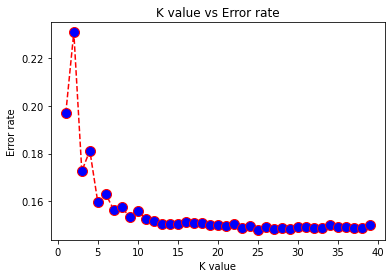

In [15]:
error_rate = []
start_time = time()
for i in range(1, 40):
  clf_knn = KNeighborsClassifier(n_neighbors=i)
  score = cross_val_score(clf_knn, x_train, y_train, cv=10)
  error_rate.append(1 - score.mean())
end_time = time()
print(f'Время перебора моделей KNN с разным числом соседей (от 1 до 40) на обучающей выборке: {(end_time - start_time):.2f} секунд')
    
plt.plot(range(1, 40), error_rate, color='red', linestyle='dashed', marker='o', 
         markerfacecolor='blue', markersize=10)
title = 'KNN. K value vs Error rate'
plt.title('K value vs Error rate')
plt.xlabel('K value')
plt.ylabel('Error rate')
plt.savefig(f'{os.path.join(img_dir, title)}.png')

Создание и настройка модели KNN с гиперпараметрами по умолчанию. Обучение модели и вывод точности работы алгоритма на обучающей выборке. Вывод графика кривой Precision-Recall в процессе кросс-валидации

In [16]:
clf_knn = KNeighborsClassifier()
start_time = time()
clf_knn.fit(x_train, y_train)
end_time = time()
# точность работы на обучающей выборке
train_score = clf_knn.score(x_train, y_train)
print(f'Точность работы модели (KNN) на обучающей выборке: {train_score}')
print(f'Время обучения модели (KNN) на обучающей выборке: {(end_time - start_time):.2f} секунд')

# кросс-валидация и вычисление средней точности
start_time = time()
cross_val = cross_val_score(clf_knn, x_train, y_train, cv = 10)
end_time = time()
print('Cross Val Score: {}%'.format(round(cross_val.mean() * 100, 2)))
print(f'Время кросс-валидация модели (KNN) на обучающей выборке: {(end_time - start_time):.2f} секунд')

Точность работы модели (KNN) на обучающей выборке: 0.8822019761324266
Время обучения модели (KNN) на обучающей выборке: 0.84 секунд
Cross Val Score: 84.06%
Время кросс-валидация модели (KNN) на обучающей выборке: 19.71 секунд


Вычисление метрик на тестовых данных и вывод матрицы ошибок

Точность классификации: 0.84
Точность (способность классификатора не отмечать один класс другим): 0.88
Полнота (отзыв, способность классификатора отмечать все объекты одного класса): 0.93
F-мера (средневзвешенное значение точности и полноты): 0.90
Confusion matrix, without normalization
[[ 650  522]
 [ 286 3738]]


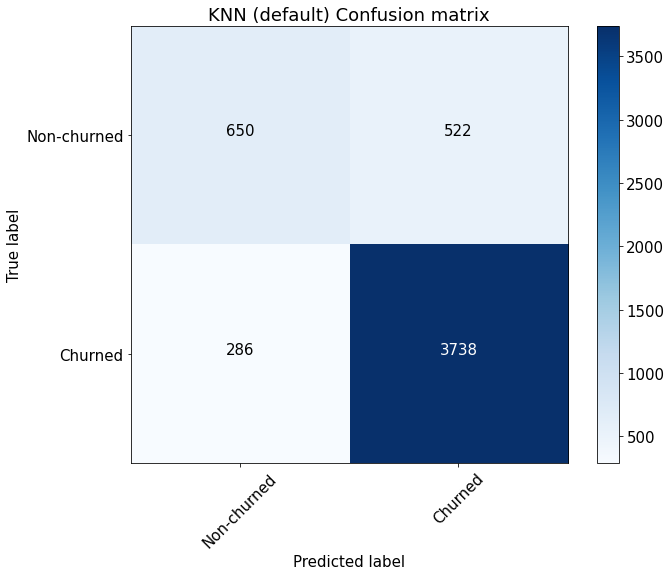

In [17]:
metrics = compute_metrics(method=clf_knn, x_test=x_test, y_test=y_test)

plot_confusion_matrix(metrics['confusion_matrix'], method_name='KNN', 
                      classes=['Non-churned', 'Churned'], 
                      title='KNN (default) Confusion matrix')

Построение кривой AUC-ROC (Area Under Curve - Receiver Operating Characteristic curve) - площадь под кривой *ошибок*

No Skill: ROC AUC=0.500
KNN: ROC AUC=0.841


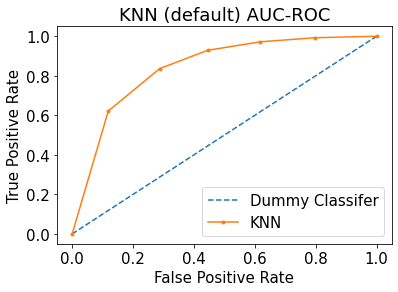

In [18]:
lr_probs = clf_knn.predict_proba(x_test)
lr_probs = lr_probs[:,1]
plot_precision_recall_ROC(x_test, y_test, lr_probs, method_name='KNN',
                          title='KNN (default) AUC-ROC')

Вывод графика для определения влияния порога на оценку 

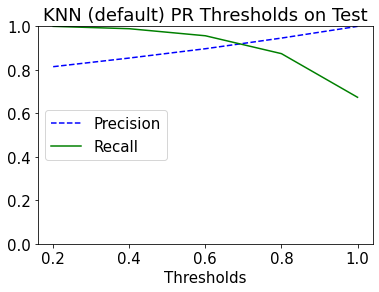

In [19]:
# вывод графика для определения влияния порога на оценку 
y_scores = clf_knn.predict_proba(x_train)[:,1]
plot_precision_recall_thresholds(y_train, y_scores, title='KNN (default) PR Thresholds on Test')

### Модель KNN с гиперпараметрами, подобранными с помощью GridSearchCV
Подбор лучших гиперпараметров с помощью GridSearchCV

In [ ]:
# weight_options = ["uniform", "distance"]
# param_grid = {
#     'n_neighbors' : list(range(1, 20)), 
#     'weights' : ['uniform', 'distance']
#     }

# clf = KNeighborsClassifier()
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# best_params = get_best_params(clf, param_grid, cv=cv, scoring='accuracy')
# best_params

Mean Accuracy: 0.849
Config: {'n_neighbors': 19, 'weights': 'distance'}


{'n_neighbors': 19, 'weights': 'distance'}

Создание модели KNN с указанием лучших гиперпараметров, подобранных с помощью GridSearchCV. Обучение модели и вывод точности работы алгоритма на обуающей выборке. Вывод графика кривой Precision-Recall в процессе кросс-валидации

In [20]:
clf_knn_cv = KNeighborsClassifier(n_neighbors=19, weights='distance')
start_time = time()
clf_knn_cv.fit(x_train, y_train)
end_time = time()
# точность работы на обучающей выборке
train_score = clf_knn_cv.score(x_train, y_train)
print(f'Точность работы модели (KNN) на обучающей выборке: {train_score}')
print(f'Время обучения модели (KNN) на обучающей выборке: {(end_time - start_time):.2f} секунд')

# кросс-валидация и вычисление средней точности
start_time = time()
cross_val = cross_val_score(clf_knn_cv, x_train, y_train, cv = 10)
end_time = time()
print('Cross Val Score: {}%'.format(round(cross_val.mean() * 100, 2)))
print(f'Время кросс-валидация модели (KNN) на обучающей выборке: {(end_time - start_time):.2f} секунд')

Точность работы модели (KNN) на обучающей выборке: 1.0
Время обучения модели (KNN) на обучающей выборке: 0.98 секунд
Cross Val Score: 85.06%
Время кросс-валидация модели (KNN) на обучающей выборке: 21.70 секунд


Вычисление метрик на тестовых данных и вывод матрицы ошибок

Точность классификации: 0.85
Точность (способность классификатора не отмечать один класс другим): 0.87
Полнота (отзыв, способность классификатора отмечать все объекты одного класса): 0.95
F-мера (средневзвешенное значение точности и полноты): 0.91
Confusion matrix, without normalization
[[ 607  565]
 [ 211 3813]]


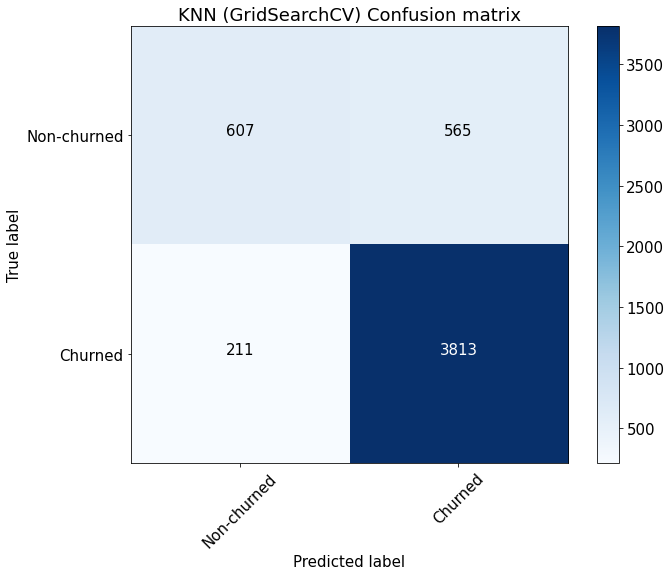

In [21]:
metrics = compute_metrics(method=clf_knn_cv, x_test=x_test, y_test=y_test)

plot_confusion_matrix(metrics['confusion_matrix'], method_name='KNN', 
                      classes=['Non-churned', 'Churned'], 
                      title='KNN (GridSearchCV) Confusion matrix')

Построение кривой AUC-ROC (Area Under Curve - Receiver Operating Characteristic curve) - площадь под кривой *ошибок*

No Skill: ROC AUC=0.500
KNN: ROC AUC=0.880


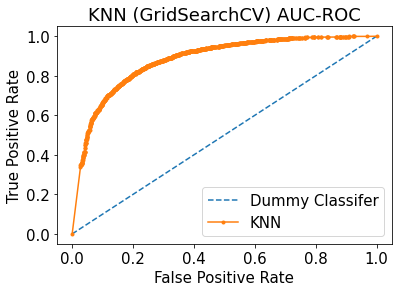

In [22]:
lr_probs = clf_knn_cv.predict_proba(x_test)
lr_probs = lr_probs[:,1]
plot_precision_recall_ROC(x_test, y_test, lr_probs, method_name='KNN',
                          title='KNN (GridSearchCV) AUC-ROC')

Вывод графика для определения влияния порога на оценку

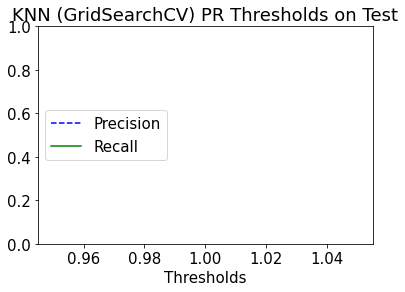

In [23]:
# вывод графика для определения влияния порога на оценку 
y_scores = clf_knn_cv.predict_proba(x_train)[:,1]
plot_precision_recall_thresholds(y_train, y_scores, title='KNN (GridSearchCV) PR Thresholds on Test')